In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

# Evaluation metrics
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

# Import SpaLP modules    Python package: https://github.com/dbjzs/SpaLP
from SpaLP.LP import SpatialLocalPooling
from SpaLP.utils import set_seed, prepare_inputs
# Set random seed
set_seed(7)

#Check the GPU memory and CPU memory
import memory_profiler  # pip install memory_profiler
import torch
import gc

# Check device
import cpuinfo   # pip install py-cpuinfo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
info = cpuinfo.get_cpu_info()
print("CPU:", info['brand_raw'])

Using device: cuda
GPU: NVIDIA A800-SXM4-80GB
CPU: Intel(R) Xeon(R) Platinum 8462Y+


In [2]:
#Check the GPU memory and CPU memory
from memory_profiler import memory_usage
def measure_resources(func):
    def wrapper(*args, **kwargs):
        gc.collect()
        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        
        before = memory_usage(-1, interval=0.1, timeout=1)[0]
        mem_peak, result = memory_usage((func, args, kwargs),max_usage=True,retval=True)
        print(f"CPU peak memory: {(mem_peak - before)/1024:.2f} GB")
        
        torch.cuda.synchronize()
        gpu_peak = torch.cuda.max_memory_allocated() / 1024**3
        print(f"GPU peak memory: {gpu_peak:.2f} GB")
        return result
    return wrapper

In [3]:
def train_spalp(graph, in_channels, hidden_dim, epochs, lr, device,seed):
    """Train SpaLP model and return embeddings."""
    from tqdm.auto import tqdm
    set_seed(seed)
    pbar = tqdm(range(epochs), desc="Training",ncols=200)
    model = SpatialLocalPooling(in_channels, hidden_dim).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    losses = []
    
    for epoch in pbar:
        start_time = time.time()
        model.train()
        optimizer.zero_grad()
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        loss = criterion(reconstructed, graph.features)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        elapsed = time.time() - start_time
        pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})
    
    # Get final embeddings
    model.eval()
    with torch.no_grad():
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        reconstructed = reconstructed.cpu().numpy()
        embedding=embedding.cpu().numpy()
    return embedding,reconstructed, losses

In [4]:
def evaluate_clustering(adata, pred_key=None, true_key=None):
    metrics = {}
    true_labels = np.array(adata.obs[true_key])
    cluster_labels = np.array(adata.obs[pred_key])
    
    metrics['ARI'] = adjusted_rand_score(true_labels, cluster_labels)
    metrics['NMI'] = normalized_mutual_info_score(true_labels, cluster_labels)
    metrics['AMI'] = adjusted_mutual_info_score(true_labels, cluster_labels)
    metrics['FMI'] = fowlkes_mallows_score(true_labels, cluster_labels)
    metrics['V-Measure'] = v_measure_score(true_labels, cluster_labels)
    metrics['Homogeneity'] = homogeneity_score(true_labels, cluster_labels)
    
    print(f"  ARI: {metrics['ARI']:.4f}")
    print(f"  NMI: {metrics['NMI']:.4f}")
    print(f"  AMI: {metrics['AMI']:.4f}")
    print(f"  FMI: {metrics['FMI']:.4f}")
    print(f"  V-Measure: {metrics['V-Measure']:.4f}")
    print(f"  Homogeneity: {metrics['Homogeneity']:.4f}")
    
    return metrics

# Dataset 1: Xenium Breast Cancer (167K cells)

In [5]:
# Load Xenium Breast Cancer data
adata = sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/Xenium_Breast_Cancer.h5ad')
adata.var_names_make_unique()
print(f"Shape: {adata.shape[0]:,} cells x {adata.shape[1]:,} genes")
print(f"obsm keys: {list(adata.obsm.keys())}")

Shape: 167,780 cells x 313 genes
obsm keys: ['spatial']


In [6]:
adata

AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'ensemble_id', 'type'
    obsm: 'spatial'

In [7]:
# Preprocessing standardization  *******
start_time = time.time()
sc.pp.normalize_total(adata, target_sum=1e4,inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (167780, 2)
Preprocessing standardization: 0.56s


In [8]:
# Set the hyperparameters  k=3
k=3
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=64
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 313


In [9]:
# Build neighbor graph  k=3
start_time = time.time()
graph = prepare_inputs(adata, k=k,device=device)
prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 0.24s


### Runtime/GPU peak memory/CPU peak memory

In [10]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding,reconstructed, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding
adata.layers['rec']=reconstructed

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.37it/s, Epoch=199, Loss=0.8892]


CPU peak memory: 0.66 GB
GPU peak memory: 2.01 GB
Training time: 9.90s
CPU times: user 8.59 s, sys: 344 ms, total: 8.94 s
Wall time: 9.9 s


In [11]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, resolution=0.4, random_state=2024, key_added="SpaLP")#The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

Leiden time: 6min 13.45s
UMAP time: 1min 18.23s
Found 12 clusters
CPU times: user 14min 27s, sys: 6min 46s, total: 21min 14s
Wall time: 7min 31s


In [12]:
%%time
# KMeans time
from sklearn.cluster import KMeans
leiden_cluster=len(adata.obs['SpaLP'].unique())
kmeans = KMeans(n_clusters=leiden_cluster, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)  #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 14.9 s, sys: 19.6 s, total: 34.4 s
Wall time: 655 ms


In [13]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig2Xenium_breast_cancer.h5ad',compression='gzip')  #Save the embedding for rapid single-cell (GPU-scanpy) analysis.

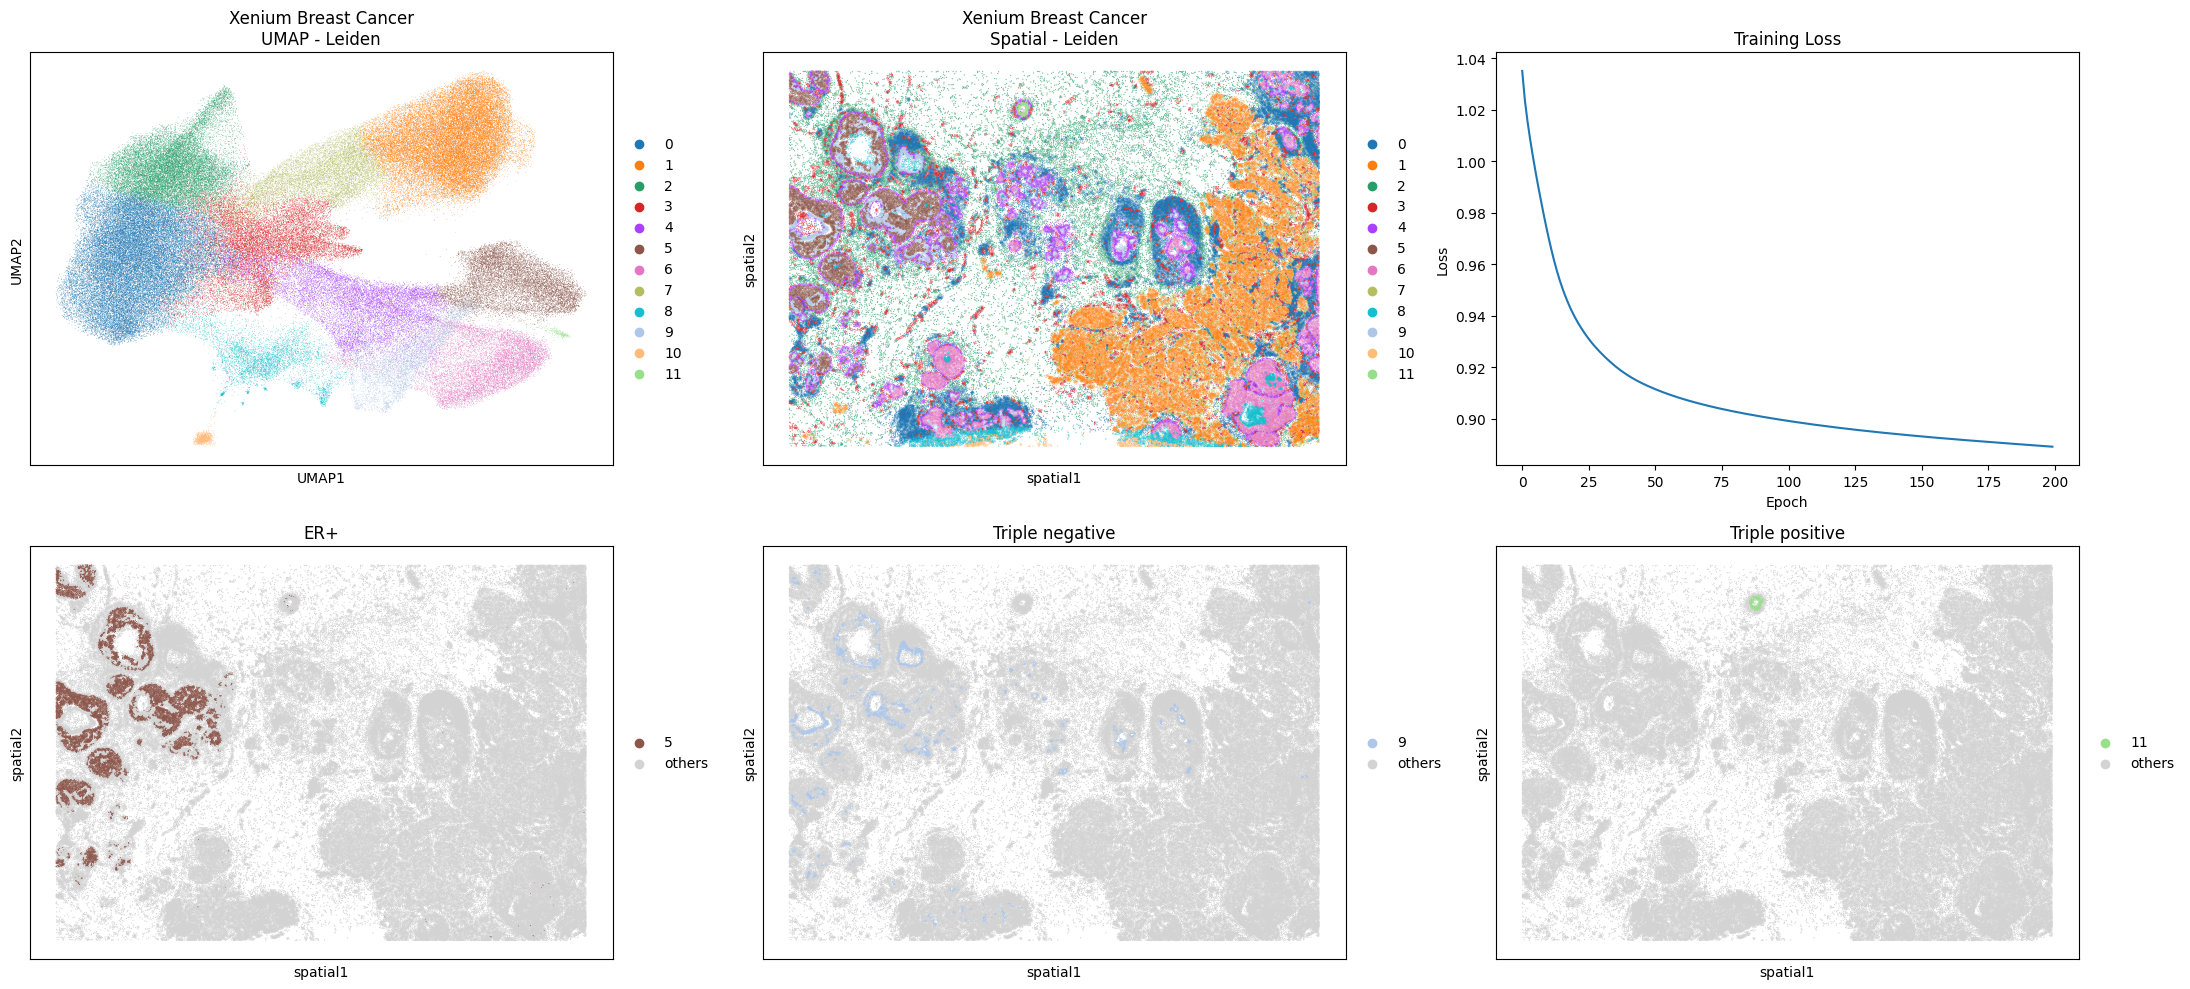

In [14]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(22, 10))
# UMAP with legend
sc.pl.umap(adata, color='SpaLP', ax=axes[0, 0], show=False, title='Xenium Breast Cancer\nUMAP - Leiden', legend_loc='right margin')

# Spatial with legend using scanpy
sc.pl.embedding(adata, basis='spatial', color='SpaLP', ax=axes[0, 1], show=False, title='Xenium Breast Cancer\nSpatial - Leiden', s=3, alpha=0.7, legend_loc='right margin')

# Training loss
axes[0, 2].plot(losses)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].set_title('Training Loss')

#Cluster highlight
orig_colors = adata.uns['SpaLP_colors']
highlight_clusters = {5: "ER+",9: "Triple negative",11: "Triple positive"}
for col, (cluster_id, title) in enumerate(highlight_clusters.items()):
    
    highlight_color = orig_colors[cluster_id]
    adata.obs['SpaLP_highlight'] = np.where(adata.obs['SpaLP'].astype(str) == str(cluster_id),str(cluster_id),'others')
    sc.pl.embedding(adata,basis='spatial',color='SpaLP_highlight',palette={str(cluster_id): highlight_color, 'others': 'lightgrey'},ax=axes[1,col],show=False,s=3,title=title)

plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig2/Fig2_Xenium_Breast_cancer.png', dpi=150, bbox_inches='tight')
plt.show()

# Dataset 2: CosMx Mouse Brain (48K cells)
Run 3 times with different random seeds to assess reproducibility and variance.

In [15]:
# Load CosMx Mouse Brain data
adata = sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/CosMxMouseBrain.h5ad')
adata.var_names_make_unique()
print(f"Shape: {adata.shape[0]:,} cells x {adata.shape[1]:,} genes")
print(f"obsm keys: {list(adata.obsm.keys())}")

Shape: 48,180 cells x 950 genes
obsm keys: ['spatial']


In [16]:
adata

AnnData object with n_obs × n_vars = 48180 × 950
    obs: 'spatialClusteringAssignments'
    uns: 'RNA_nbclust_clusters_colors', 'spatialClusteringAssignments_colors'
    obsm: 'spatial'

In [17]:
# Preprocessing standardization  *******
start_time = time.time()
sc.pp.normalize_total(adata,inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (48180, 2)
Preprocessing standardization: 0.47s


In [18]:
# Set the hyperparameters  k=8
k=8
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=64
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 950


In [19]:
%%time
# Run 4 times with different seeds
SEEDS = [7, 42, 123, 456]
results_cosmx = {}

for i, seed in enumerate(SEEDS):
    print(f"\n{'='*60}")
    print(f"Run {i+1}/4 - Seed: {seed}")
    print(f"{'='*60}")
    
    # Set seed
    set_seed(seed)
    
    # Create a copy for this run
    adata_run = adata.copy()
    
    # Build neighbor graph and train
    start_time = time.time()
    graph = prepare_inputs(adata_run, k=k, device=device)  
    prep_time = time.time() - start_time
    print(f"Graph preparation: {prep_time:.2f}s")

    start_time = time.time()
    @measure_resources
    def run_train():
        return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=seed)#Run 4 times with different seeds.
    embedding, losses = run_train()
    train_time = time.time() - start_time
    print(f"Training time: {train_time:.2f}s")
    
    # Store embeddings
    adata_run.obsm['SpaLP'] = embedding
    
    # Clustering and UMAP
    sc.pp.neighbors(adata_run, use_rep='SpaLP')
    sc.tl.leiden(adata_run, random_state=2024, resolution=0.655,key_added='SpaLP') #The clustering results save in adata.obs['SpaLP']
    sc.tl.umap(adata_run)
    
    n_clusters = len(adata_run.obs['SpaLP'].unique())
    print(f"Found {n_clusters} clusters")
    
    # Evaluate clustering
    print(f"\nEvaluating Run {i+1}:")
    metrics = evaluate_clustering(adata_run, pred_key='SpaLP', true_key='spatialClusteringAssignments')
    
    # Store results
    results_cosmx[f'run_{i+1}'] = {'seed': seed,'adata': adata_run,'losses': losses,'metrics': metrics,'train_time': train_time,'n_clusters': n_clusters}
print("\n" + "="*60)
print("All 4 runs completed!")
print("="*60)


Run 1/4 - Seed: 7
Graph preparation: 0.09s


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 51.02it/s, Epoch=199, Loss=0.9202]


CPU peak memory: 0.14 GB
GPU peak memory: 1.85 GB
Training time: 5.42s
Found 19 clusters

Evaluating Run 1:
  ARI: 0.5787
  NMI: 0.7305
  AMI: 0.7302
  FMI: 0.6167
  V-Measure: 0.7305
  Homogeneity: 0.7434

Run 2/4 - Seed: 42
Graph preparation: 0.09s


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 50.67it/s, Epoch=199, Loss=0.9160]


CPU peak memory: 0.08 GB
GPU peak memory: 1.85 GB
Training time: 5.46s
Found 21 clusters

Evaluating Run 2:
  ARI: 0.4988
  NMI: 0.7092
  AMI: 0.7088
  FMI: 0.5442
  V-Measure: 0.7092
  Homogeneity: 0.7207

Run 3/4 - Seed: 123
Graph preparation: 0.09s


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 50.54it/s, Epoch=199, Loss=0.9155]


CPU peak memory: 0.07 GB
GPU peak memory: 1.85 GB
Training time: 5.50s
Found 20 clusters

Evaluating Run 3:
  ARI: 0.5157
  NMI: 0.7126
  AMI: 0.7122
  FMI: 0.5592
  V-Measure: 0.7126
  Homogeneity: 0.7367

Run 4/4 - Seed: 456
Graph preparation: 0.09s


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 50.62it/s, Epoch=199, Loss=0.9173]


CPU peak memory: 0.08 GB
GPU peak memory: 1.85 GB
Training time: 5.54s
Found 20 clusters

Evaluating Run 4:
  ARI: 0.5418
  NMI: 0.7266
  AMI: 0.7263
  FMI: 0.5830
  V-Measure: 0.7266
  Homogeneity: 0.7445

All 4 runs completed!
CPU times: user 10min 27s, sys: 5min 20s, total: 15min 48s
Wall time: 3min 52s


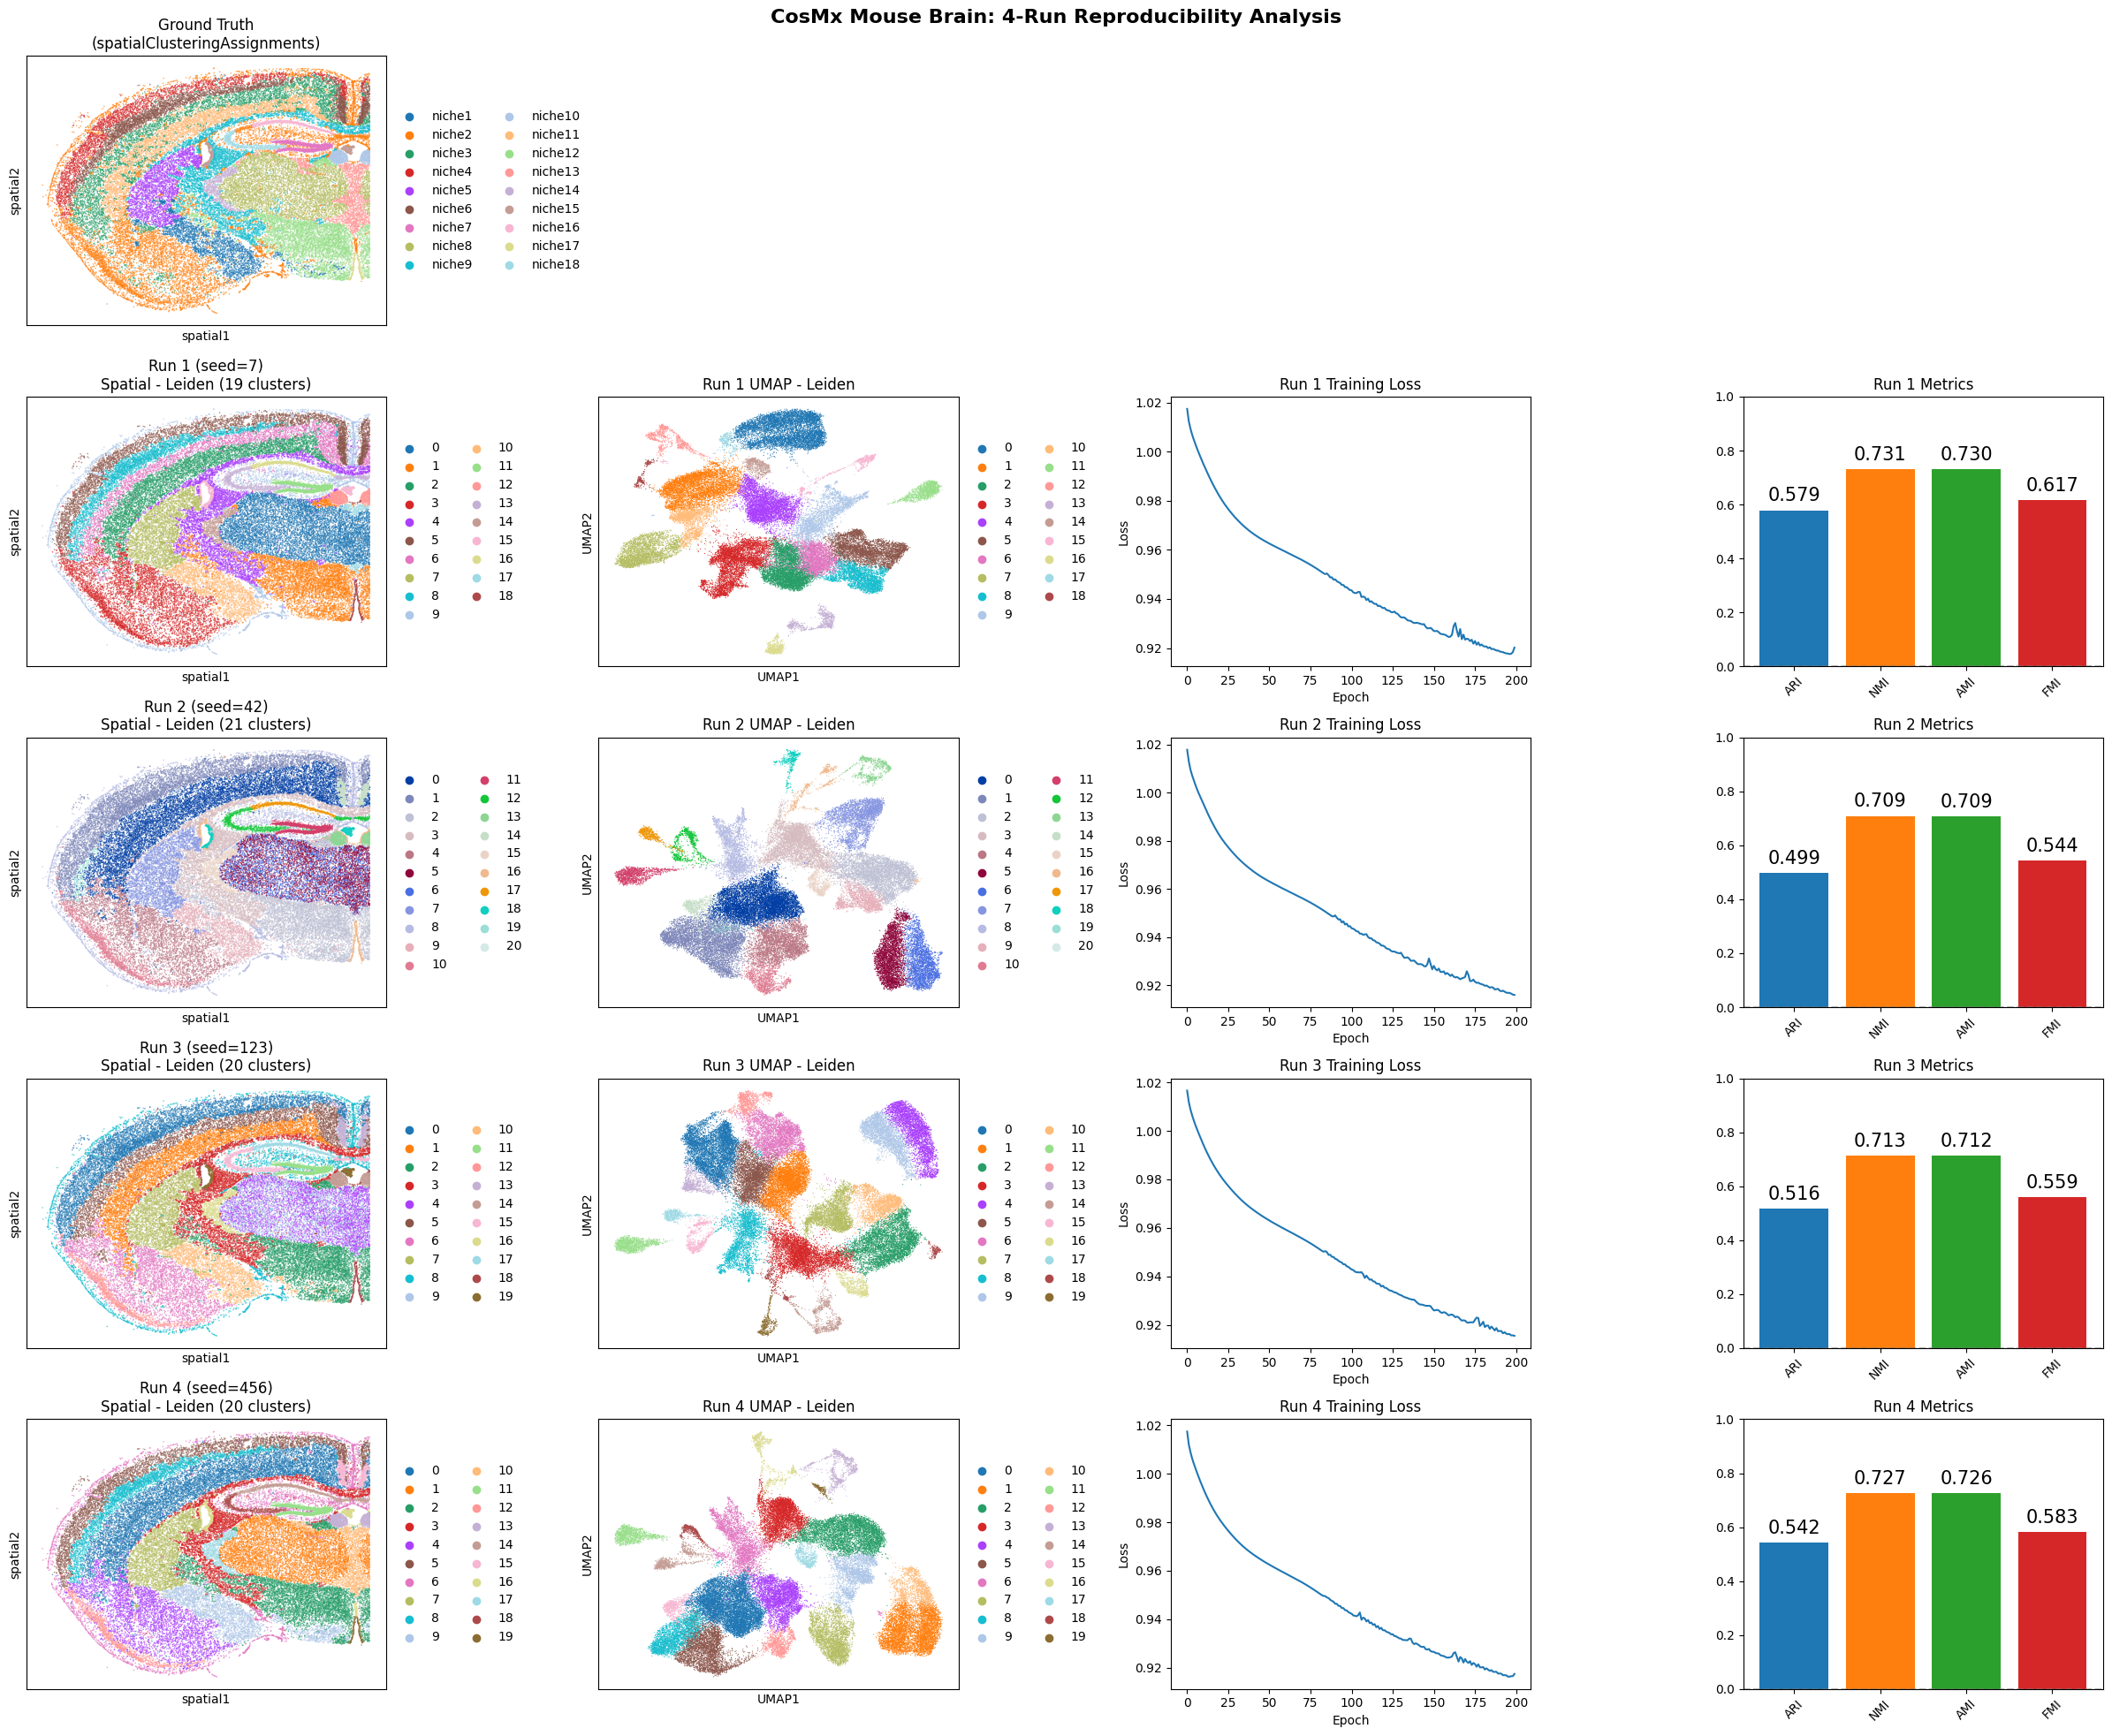

In [20]:
# Visualization - Compare all 3 runs
fig, axes = plt.subplots(5, 4, figsize=(24, 20))

# Row 0: Ground truth (same for all)
sc.pl.embedding(adata, basis='spatial', color='spatialClusteringAssignments', ax=axes[0, 0], show=False,
                title=f'Ground Truth\n(spatialClusteringAssignments)', s=5, alpha=0.7, legend_loc='right margin')

# Hide unused cells in row 0
for j in range(1, 4):
    axes[0, j].axis('off')

# Rows 1-4: Each run
for i, (run_name, run_data) in enumerate(results_cosmx.items()):
    row = i + 1
    adata_run = run_data['adata']
    metrics = run_data['metrics']
    losses = run_data['losses']
    seed = run_data['seed']
    n_clusters = run_data['n_clusters']
    
    # Spatial - Leiden with legend
    sc.pl.embedding(adata_run, basis='spatial', color='SpaLP', ax=axes[row, 0], show=False,
                    title=f'Run {i+1} (seed={seed})\nSpatial - Leiden ({n_clusters} clusters)', 
                    s=5, alpha=0.7, legend_loc='right margin')
    
    # UMAP with legend
    sc.pl.umap(adata_run, color='SpaLP', ax=axes[row, 1], show=False, 
               title=f'Run {i+1} UMAP - Leiden', legend_loc='right margin')
    
    # Training loss
    axes[row, 2].plot(losses)
    axes[row, 2].set_xlabel('Epoch')
    axes[row, 2].set_ylabel('Loss')
    axes[row, 2].set_title(f'Run {i+1} Training Loss')
    
    # Metrics bar chart
    metric_names_plot = ['ARI', 'NMI', 'AMI', 'FMI']
    metric_values = [metrics.get(m, 0) for m in metric_names_plot]
    bars = axes[row, 3].bar(range(len(metric_names_plot)), metric_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[row, 3].set_xticks(range(len(metric_names_plot)))
    axes[row, 3].set_xticklabels(['ARI', 'NMI', 'AMI', 'FMI'], rotation=45)
    axes[row, 3].set_ylim([0, 1.0])
    axes[row, 3].set_title(f'Run {i+1} Metrics')
    axes[row, 3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, metric_values):
        axes[row, 3].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                          f'{val:.3f}', ha='center', va='bottom', fontsize=15)

plt.suptitle('CosMx Mouse Brain: 4-Run Reproducibility Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig2/Fig2_CosMxMouseBrain_4runs.png', dpi=150, bbox_inches='tight')
plt.show()

# Dataset 3: Simulated Data (640K cells)

In [21]:
# Load Simulated data
adata = sc.read_h5ad('/home/dbj/HERGAST/simulatedata.h5ad')
adata.var_names_make_unique()
print(f"Shape: {adata.shape[0]:,} cells x {adata.shape[1]:,} genes")
print(f"obsm keys: {list(adata.obsm.keys())}")

Shape: 640,000 cells x 31,493 genes
obsm keys: ['X_scanvi_emb', 'X_umap', 'spatial']


For datasets with more than 5000 genes, the usual analysis would select the top 2000 highly variable genes.

In [22]:
# Preprocessing standardization  *******
start_time = time.time()
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')  #select the top 2000 highly variable genes
adata = adata[:,adata.var.highly_variable]
adata.raw=adata

#Preprocessing standardization
sc.pp.normalize_total(adata, target_sum=1e4,inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat'] = adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (640000, 2)
Preprocessing standardization: 59.26s


In [23]:
# Set the hyperparameters  k=8
k=5
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=64
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 2000


In [24]:
# Build neighbor graph  k=3
start_time = time.time()
graph = prepare_inputs(adata, k=k,device=device)
prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 1.49s


In [25]:
%%time
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.88it/s, Epoch=199, Loss=0.9247]


CPU peak memory: 4.75 GB
GPU peak memory: 29.68 GB
Training time: 57.33s
CPU times: user 52.6 s, sys: 3.68 s, total: 56.3 s
Wall time: 57.3 s


In [26]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, random_state=2024, resolution=0.013,key_added='SpaLP')#The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

Leiden time: 11min 17.99s


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


UMAP time: 7min 8.85s
Found 11 clusters
CPU times: user 1h 23min 47s, sys: 48min 34s, total: 2h 12min 21s
Wall time: 18min 26s


In [27]:
%%time
# KMeans time
from sklearn.cluster import KMeans
leiden_clusters = len(adata.obs['SpaLP'].unique())
kmeans = KMeans(n_clusters=leiden_clusters, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)  #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 33.5 s, sys: 57.3 s, total: 1min 30s
Wall time: 1.84 s


In [28]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig2simulation.h5ad',compression='gzip')  #Save the embedding for rapid single-cell (GPU-scanpy) analysis.

In [29]:
# Evaluate clusterin1g
# Ground truth: ann_level_3
print("Evaluating Simulated Data clustering:")
metrics_sim = evaluate_clustering(adata, pred_key='SpaLP', true_key='ann_level_3')
print(f"\nSummary: {metrics_sim}")

Evaluating Simulated Data clustering:
  ARI: 0.8997
  NMI: 0.8768
  AMI: 0.8768
  FMI: 0.9322
  V-Measure: 0.8768
  Homogeneity: 0.8780

Summary: {'ARI': 0.899744008804288, 'NMI': 0.8768092938043112, 'AMI': 0.8768042502418241, 'FMI': 0.9321627759919207, 'V-Measure': 0.876809293804311, 'Homogeneity': 0.8780196203054496}


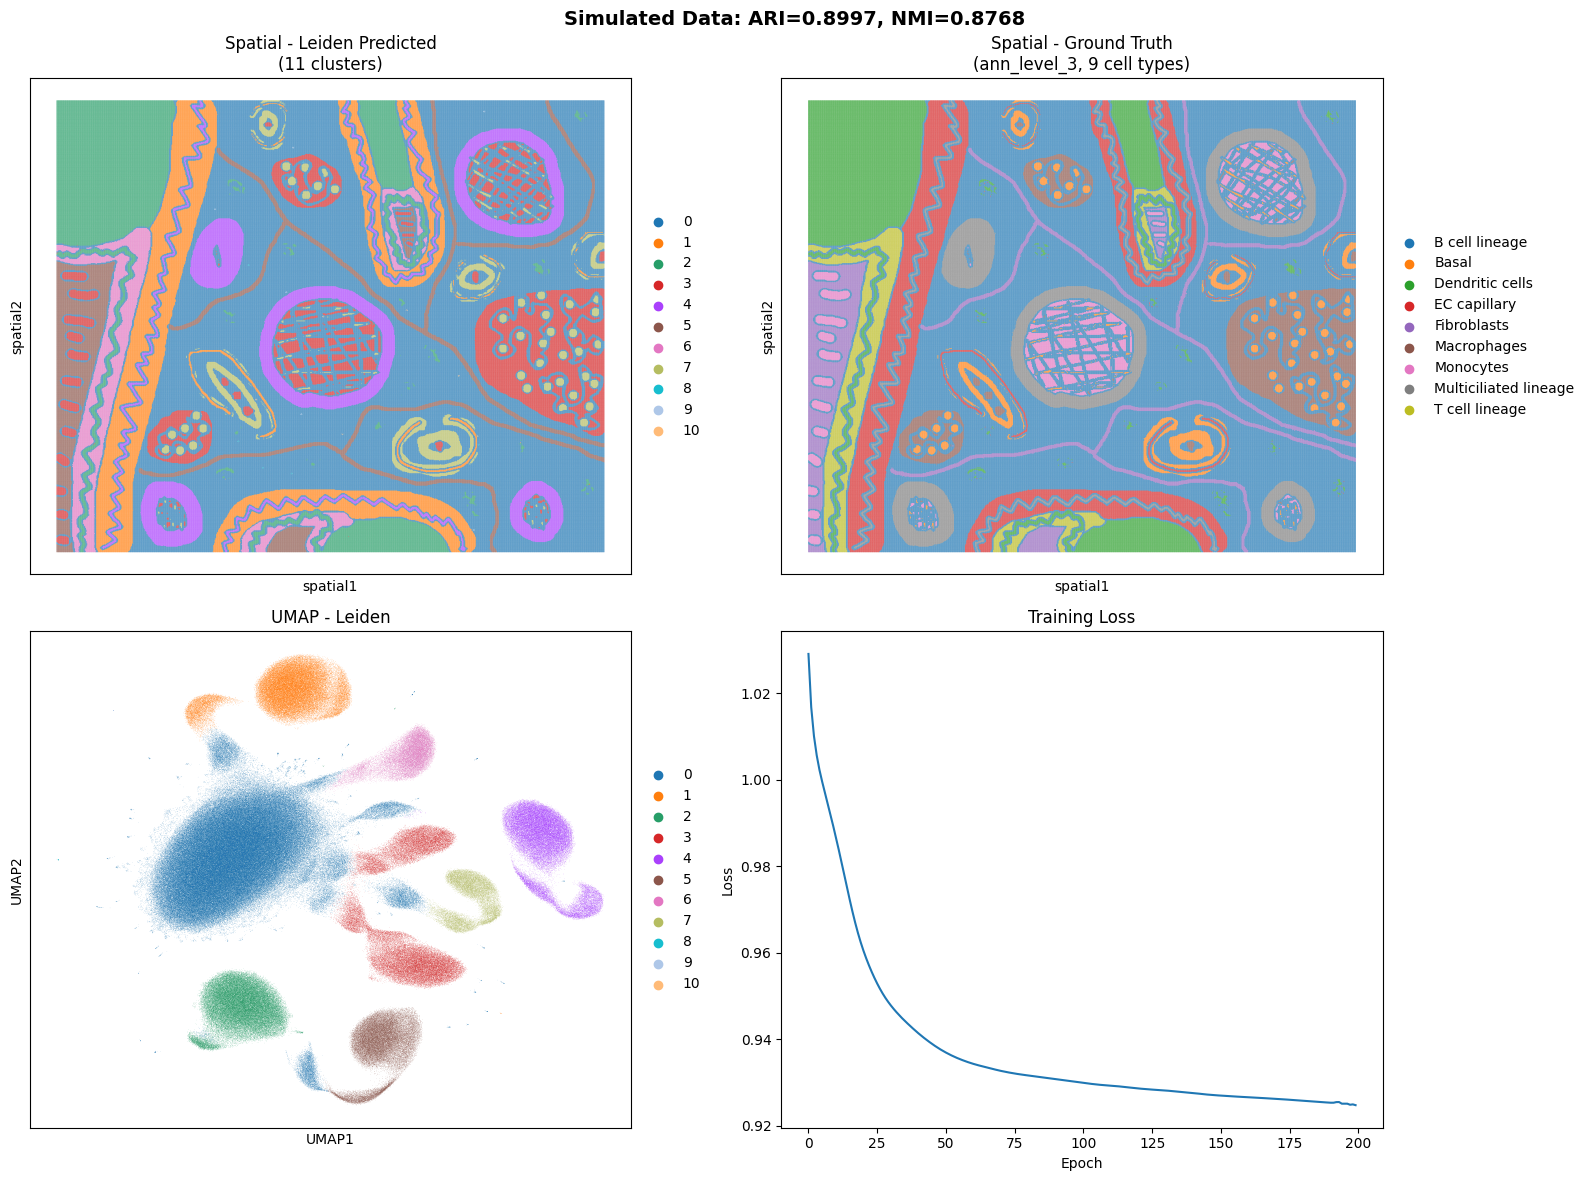

In [30]:
# Visualization - compare predicted clusters with ground truth
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Row 1: Spatial views side by side for comparison
n_clusters = len(adata.obs['SpaLP'].unique())
n_gt_clusters = len(adata.obs['ann_level_3'].unique())

# Spatial - Leiden (predicted) with legend
sc.pl.embedding(adata, basis='spatial', color='SpaLP', ax=axes[0, 0], show=False,
                title=f'Spatial - Leiden Predicted\n({n_clusters} clusters)', 
                s=1, alpha=1, legend_loc='right margin')

# Spatial - Ground Truth (ann_level_3) with legend
sc.pl.embedding(adata, basis='spatial', color='ann_level_3', ax=axes[0, 1], show=False,
                title=f'Spatial - Ground Truth\n(ann_level_3, {n_gt_clusters} cell types)', 
                s=1, alpha=1, legend_loc='right margin')

# Row 2: UMAP and Training Loss
sc.pl.umap(adata, color='SpaLP', ax=axes[1, 0], show=False, title='UMAP - Leiden', legend_loc='right margin')

axes[1, 1].plot(losses)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Training Loss')

plt.suptitle(f'Simulated Data: ARI={metrics_sim.get("ARI", 0):.4f}, NMI={metrics_sim.get("NMI", 0):.4f}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig2/Fig2_simulatedata.png', dpi=150, bbox_inches='tight')
plt.show()

In [31]:
%%time
# Run 4 times with different seeds
SEEDS = [7, 42, 123, 456]
results_cosmx = {}

for i, seed in enumerate(SEEDS):
    print(f"\n{'='*60}")
    print(f"Run {i+1}/4 - Seed: {seed}")
    print(f"{'='*60}")
    
    # Set seed
    set_seed(seed)
    
    # Create a copy for this run
    adata_run = adata.copy()
    
    # Build neighbor graph and train
    start_time = time.time()
    graph = prepare_inputs(adata_run, k=k, device=device)  
    prep_time = time.time() - start_time
    print(f"Graph preparation: {prep_time:.2f}s")

    start_time = time.time()
    @measure_resources
    def run_train():
        return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=seed)#Run 4 times with different seeds.
    embedding, losses = run_train()
    train_time = time.time() - start_time
    print(f"Training time: {train_time:.2f}s")
    
    # Store embeddings
    adata_run.obsm['SpaLP'] = embedding
    
    # Clustering and UMAP
    sc.pp.neighbors(adata_run, use_rep='SpaLP')
    sc.tl.leiden(adata_run, random_state=2024, resolution=0.013,key_added='SpaLP') #The clustering results save in adata.obs['SpaLP']
    sc.tl.umap(adata_run)
    
    n_clusters = len(adata_run.obs['SpaLP'].unique())
    print(f"Found {n_clusters} clusters")
    
    # Evaluate clustering
    print(f"\nEvaluating Run {i+1}:")
    metrics = evaluate_clustering(adata_run, pred_key='SpaLP', true_key='ann_level_3')
    
    # Store results
    results_cosmx[f'run_{i+1}'] = {'seed': seed,'adata': adata_run,'losses': losses,'metrics': metrics,'train_time': train_time,'n_clusters': n_clusters}
print("\n" + "="*60)
print("All 4 runs completed!")
print("="*60)


Run 1/4 - Seed: 7
Graph preparation: 1.64s


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.89it/s, Epoch=199, Loss=0.9247]


CPU peak memory: 4.81 GB
GPU peak memory: 29.68 GB
Training time: 55.91s
Found 11 clusters

Evaluating Run 1:
  ARI: 0.8997
  NMI: 0.8768
  AMI: 0.8768
  FMI: 0.9322
  V-Measure: 0.8768
  Homogeneity: 0.8780

Run 2/4 - Seed: 42
Graph preparation: 1.55s


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.89it/s, Epoch=199, Loss=0.9247]


CPU peak memory: 4.86 GB
GPU peak memory: 29.68 GB
Training time: 56.30s
Found 10 clusters

Evaluating Run 2:
  ARI: 0.7688
  NMI: 0.8131
  AMI: 0.8131
  FMI: 0.8508
  V-Measure: 0.8131
  Homogeneity: 0.7669

Run 3/4 - Seed: 123
Graph preparation: 1.56s


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.89it/s, Epoch=199, Loss=0.9256]


CPU peak memory: 4.79 GB
GPU peak memory: 29.68 GB
Training time: 56.27s
Found 12 clusters

Evaluating Run 3:
  ARI: 0.8311
  NMI: 0.8386
  AMI: 0.8386
  FMI: 0.8881
  V-Measure: 0.8386
  Homogeneity: 0.8059

Run 4/4 - Seed: 456
Graph preparation: 1.63s


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.89it/s, Epoch=199, Loss=0.9250]


CPU peak memory: 4.81 GB
GPU peak memory: 29.68 GB
Training time: 56.29s
Found 12 clusters

Evaluating Run 4:
  ARI: 0.7945
  NMI: 0.8129
  AMI: 0.8128
  FMI: 0.8620
  V-Measure: 0.8129
  Homogeneity: 0.7914

All 4 runs completed!
CPU times: user 5h 22min 16s, sys: 3h 19min 37s, total: 8h 41min 53s
Wall time: 1h 6min 4s


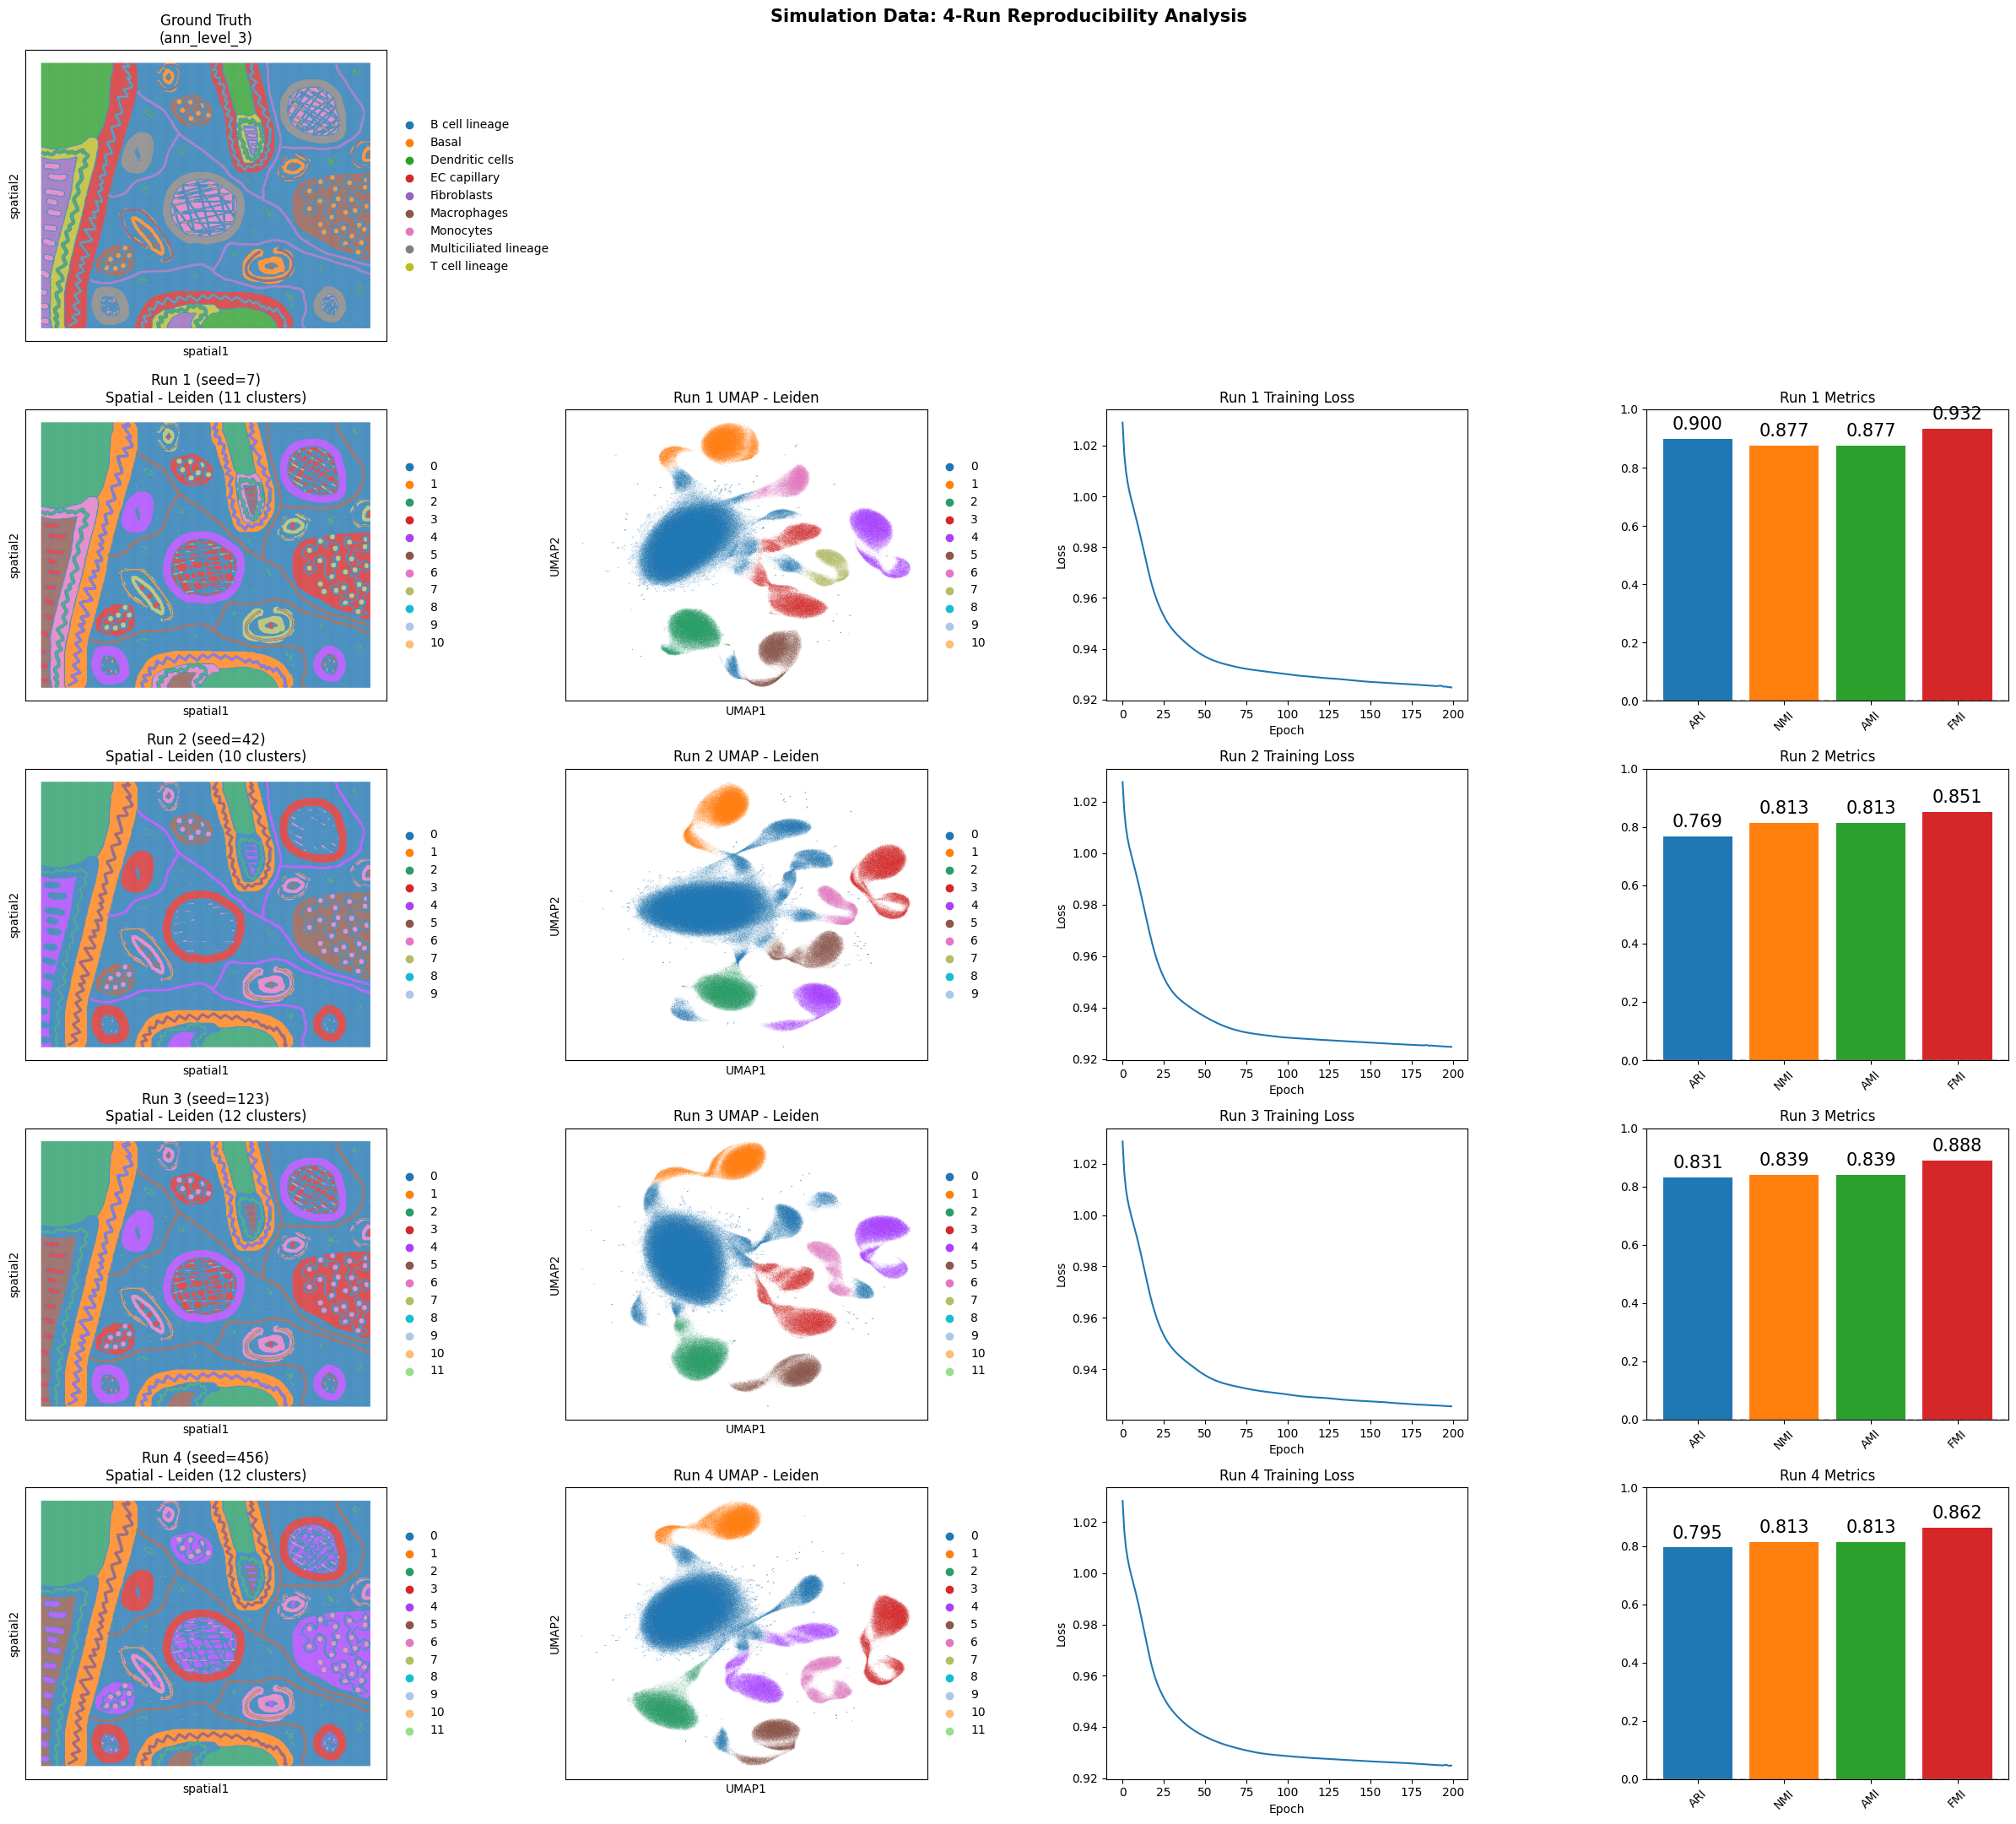

In [32]:
# Visualization - Compare all 4 runs
fig, axes = plt.subplots(5, 4, figsize=(24, 22))

# Row 0: Ground truth (same for all)
sc.pl.embedding(adata, basis='spatial', color='ann_level_3', ax=axes[0, 0], show=False,
                title=f'Ground Truth\n(ann_level_3)', s=1, alpha=0.7, legend_loc='right margin')

# Hide unused cells in row 0
for j in range(1, 4):
    axes[0, j].axis('off')

# Rows 1-4: Each run
for i, (run_name, run_data) in enumerate(results_cosmx.items()):
    row = i + 1
    adata_run = run_data['adata']
    metrics = run_data['metrics']
    losses = run_data['losses']
    seed = run_data['seed']
    n_clusters = run_data['n_clusters']
    
    # Spatial - Leiden with legend
    sc.pl.embedding(adata_run, basis='spatial', color='SpaLP', ax=axes[row, 0], show=False,
                    title=f'Run {i+1} (seed={seed})\nSpatial - Leiden ({n_clusters} clusters)', 
                    s=1, alpha=0.7, legend_loc='right margin')
    
    # UMAP with legend
    sc.pl.umap(adata_run, color='SpaLP', ax=axes[row, 1], show=False, 
               title=f'Run {i+1} UMAP - Leiden', legend_loc='right margin')
    
    # Training loss
    axes[row, 2].plot(losses)
    axes[row, 2].set_xlabel('Epoch')
    axes[row, 2].set_ylabel('Loss')
    axes[row, 2].set_title(f'Run {i+1} Training Loss')
    
    # Metrics bar chart
    metric_names_plot = ['ARI', 'NMI', 'AMI', 'FMI']
    metric_values = [metrics.get(m, 0) for m in metric_names_plot]
    bars = axes[row, 3].bar(range(len(metric_names_plot)), metric_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[row, 3].set_xticks(range(len(metric_names_plot)))
    axes[row, 3].set_xticklabels(['ARI', 'NMI', 'AMI', 'FMI'], rotation=45)
    axes[row, 3].set_ylim([0, 1.0])
    axes[row, 3].set_title(f'Run {i+1} Metrics')
    axes[row, 3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, metric_values):
        axes[row, 3].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                          f'{val:.3f}', ha='center', va='bottom', fontsize=15)

plt.suptitle('Simulation Data: 4-Run Reproducibility Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig2/Fig2_Simulation_4runs.png', dpi=150, bbox_inches='tight')
plt.show()